# Building a feedforward network: a classification problem

In [2]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Brief introduction to PyTorch: tensors

[PyTorch documentation](https://pytorch.org/docs/stable/index.html)


We can think of tensors as the PyTorch counterpart of NumPy arrays. Moreover, they offer a several advantages:
- They can run on GPUs or other hardware accelerators.
- They are optimized for automatic differentiation (backpropagation).
- Tensors and NumPy arrays share the same underlying memory.

In [3]:
# from list to tensor
x = [[1, 2],[3, 4]]
x_tensor = torch.tensor(x)
x_tensor

tensor([[1, 2],
        [3, 4]])

In [4]:
# from numpy array to tensor
x_array = np.array(x)
x_tensor = torch.from_numpy(x_array)
x_tensor

tensor([[1, 2],
        [3, 4]])

In [5]:
# tensor of ones with the same shape as x_tensor
x_ones = torch.ones_like(x_tensor)
x_ones

tensor([[1, 1],
        [1, 1]])

In [8]:
# random tensor with the same shape of x_tensor
x_rand = torch.rand_like(x_tensor, dtype=torch.float)
x_rand

tensor([[0.6732, 0.5147],
        [0.4879, 0.8367]])

In [9]:
# build tensors of a given shape
shape = (2,3)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.1310, 0.2049, 0.3168],
        [0.9918, 0.8931, 0.5128]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [10]:
# tensor attributes
tensor = torch.rand(3,4)

print(f"Shape: {tensor.shape}")
print(f"Datatype: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape: torch.Size([3, 4])
Datatype: torch.float32
Device tensor is stored on: cpu


In [8]:
tensor = torch.arange(12).reshape((3,4))
print(f"Tensor: {tensor}")
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[:, -1]}")
tensor[:,1] = 0
print(tensor)

Tensor: tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
First row: tensor([0, 1, 2, 3])
First column: tensor([0, 4, 8])
Last column: tensor([ 3,  7, 11])
tensor([[ 0,  0,  2,  3],
        [ 4,  0,  6,  7],
        [ 8,  0, 10, 11]])


In [9]:
# concatenate tensors
conc_tensor = torch.cat([tensor, tensor, tensor], dim=1)
conc_tensor

tensor([[ 0,  0,  2,  3,  0,  0,  2,  3,  0,  0,  2,  3],
        [ 4,  0,  6,  7,  4,  0,  6,  7,  4,  0,  6,  7],
        [ 8,  0, 10, 11,  8,  0, 10, 11,  8,  0, 10, 11]])

In [10]:
# tensor multiplication (syntactic sugar)
t1 = tensor @ tensor.T
# tensor multiplication (explicit formulation)
t2 = tensor.matmul(tensor.T)
print(t1,t2) 

# element-wise product (syntactic sugar)
e1 = tensor * tensor
# element-wise product (explicit formulation)
e2 = tensor.mul(tensor)
print(e1,e2)

tensor([[ 13,  33,  53],
        [ 33, 101, 169],
        [ 53, 169, 285]]) tensor([[ 13,  33,  53],
        [ 33, 101, 169],
        [ 53, 169, 285]])
tensor([[  0,   0,   4,   9],
        [ 16,   0,  36,  49],
        [ 64,   0, 100, 121]]) tensor([[  0,   0,   4,   9],
        [ 16,   0,  36,  49],
        [ 64,   0, 100, 121]])


### Interoperation with NumPy 

In [11]:
# from tensor to numpy
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [12]:
# changing the tensor will also change its numpy counterpart
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


## Loading the FashionMNIST dataset

In this section, we are going to see how to train a classifier on a famous dataset, called Fashion-MNIST. It consists of Zalando’s article images, represented by $28 \times 28$ grayscale images.

The following parameters are important for the loading functions:
- `root`: is a string explicitating the path where the data are stored.
- `train`: is a boolean specifying if the dataset is for training or for test.
- `download`: is a boolean specifying to download the data (or not).
- `transform`: specify the feature transformations.

In [13]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

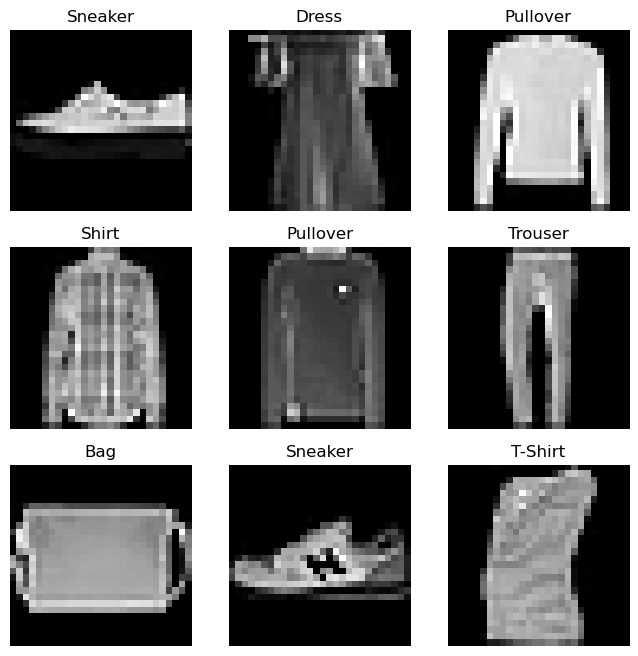

In [14]:
# plot 9 random sample of the training set
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Data Loaders

It is important to split the datasets into minibatches and to shuffle them at each epoch. `DataLoader` is a PyTorch iterable that abstracts this complexity in a simple API.

In [15]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## Build a Neural Network

In [16]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [17]:
model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
X = torch.rand(1, 28, 28)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([6])


### `nn.Flatten`

`nn.Flatten` converts each $28 \times 28$ tensor into a contigous array of length $28^2 = 784$.

In [19]:
input_image = torch.rand(3,28,28)
print(input_image.size())

flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 28, 28])
torch.Size([3, 784])


### `nn.Linear`

`nn.Linear` applies a linear transformation to the input using the stored weights and bias.

In [20]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


### `nn.ReLU`

`nn.ReLU` is the ReLU activation function.

In [21]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.2350, -0.0289,  0.1699,  0.4927, -0.3503,  0.5136,  0.4753, -0.2643,
          0.1195,  0.2828, -0.3880,  0.0331, -0.9412,  0.6458,  0.2580,  0.4402,
          0.0915, -0.1692, -0.1692,  0.4055],
        [ 0.0579, -0.1365,  0.3722,  0.5767, -0.4901,  0.2911,  0.2982, -0.7449,
         -0.2749, -0.0053, -0.2136, -0.1810, -0.9047,  0.3272,  0.0355,  0.0789,
          0.2059, -0.0081, -0.1435,  0.3834],
        [ 0.1904, -0.1059,  0.2962,  0.5991, -0.2065,  0.3181,  0.4250, -0.3816,
         -0.0279, -0.0171, -0.0984, -0.2073, -0.6598,  0.6578,  0.1427,  0.2869,
         -0.1859,  0.0947, -0.2936,  0.3301]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.2350, 0.0000, 0.1699, 0.4927, 0.0000, 0.5136, 0.4753, 0.0000, 0.1195,
         0.2828, 0.0000, 0.0331, 0.0000, 0.6458, 0.2580, 0.4402, 0.0915, 0.0000,
         0.0000, 0.4055],
        [0.0579, 0.0000, 0.3722, 0.5767, 0.0000, 0.2911, 0.2982, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3272, 0.03

### `nn.Sequential`

`nn.Sequential` is a container of different modules such that the data flows from one module to the next.

### `nn.Softmax`

Quoting PyTorch docs, "applies the Softmax function to an $n$-dimensional input Tensor rescaling them so that the elements of the $n$-dimensional output Tensor lie in the range $[0,1]$ and sum to $1$."

In [22]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)
# predicted classes
pred_probab.argmax(1)

tensor([6])

The cross-entropy loss in PyTorch applies the Softmax function to the outputs of the network to get a tensor of probabilities befor computing the loss.

## Network training

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients 
    # are computed during test mode and also serves to reduce unnecessary 
    # gradient computations and memory usage for tensors with requires_grad = True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
model = NeuralNetwork()
learning_rate = 5e-3
batch_size = 64

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310445  [   64/60000]
loss: 2.246499  [ 6464/60000]
loss: 2.133125  [12864/60000]
loss: 2.037019  [19264/60000]
loss: 1.909208  [25664/60000]
loss: 1.621199  [32064/60000]
loss: 1.510276  [38464/60000]
loss: 1.353230  [44864/60000]
loss: 1.222976  [51264/60000]
loss: 0.963214  [57664/60000]
Test Error: 
 Accuracy: 64.6%, Avg loss: 1.080397 

Epoch 2
-------------------------------
loss: 0.991990  [   64/60000]
loss: 0.991054  [ 6464/60000]
loss: 1.052297  [12864/60000]
loss: 0.881786  [19264/60000]
loss: 0.827121  [25664/60000]
loss: 1.051338  [32064/60000]
loss: 0.920639  [38464/60000]
loss: 0.756990  [44864/60000]
loss: 0.847547  [51264/60000]
loss: 0.740295  [57664/60000]
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.790329 

Epoch 3
-------------------------------
loss: 0.655202  [   64/60000]
loss: 0.744672  [ 6464/60000]
loss: 0.895342  [12864/60000]
loss: 0.821736  [19264/60000]
loss: 0.729607  [25664/60000]
loss: 0.631113  [32064/600

## Exercise:
Solve the classification problem for the MNIST dataset. Use the `torchvision.datasets.MNIST` class to load the data. Plot the _average_ lossess on the training and the test sets vs epoch number. Check the predictions of the trained model on some samples of the test dataset.